<img src="img/Creature_2021.jpg" style="width: 50%; float: right; padding: 50px" />

# Neural Expressions - Sculptural Robotics and Neural Connections
## Showcase and notebook on experimentations with Brain-to-Sculpture communication and EEG actuated robotic sculptures
(Notebook and codebase: <a href="https://github.com/slaattnes/neural-expressions/">github.com/slaattnes/neural-expressions</a>)<br/>
(Professional portfolio: <a href="https://slaattnes.com/">slaattnes.com</a>)

### Funding

Project funded by DeepCA (Norwegian Research Council, grant agreement 286558) and FeLT (Norwegian Artistic Research Programme).

License and credits:

This project is <a href="https://mit-license.org/">MIT licensed</a>. I get public funding and take freely from other's work. Resources used in this project may have other conditions and restrictions. I try to credit where it's due, please reach out if I missed someone.

- <a href="https://github.com/OpenBCI/OpenBCI_GUI">OpenBCI GUI, MIT License Copyright (c) 2018 OpenBCI<a/>
- <a href="https://github.com/Sentdex/BCI">Brain-Computer Interface workspace, MIT License Copyright (c) 2019 Sentdex<a/>
- <a href="https://github.com/RedRobotics/RedBoard">RedBoard python library, Copyright (c) 2019 Red Robotics<a/>
- <a href="https://github.com/gavinlyonsrepo/RpiMotorLib">RpiMotorLib python library, GNU GENERAL PUBLIC LICENSE Version 3, 29 June 2007<a/>


#### Overview
    
##### Sculptural robotics
    
[Robotic sculpture with EEG interface](#Robotic-sculpture-with-EEG-interface)

- Sculptural robotic actuators that react to EEG recordings. Mechanical solutions?

[Testing Platform](#Testing-Platform)
    
[Motor Control](#Motor-Control)
    
##### Brain-sculpture interfacing   
    
- The brain patterns that are used for motor control is collected with the <a href="https://openbci.com/">OpenBCI system</a> (an open-source biosensing tool)
    
[Biosignal Acquisition](#Biosignal-Acquisition)
    
##### Simulated mental imagery
    
- EEG recordings: Mental imagery of body movements. Other brain activity?    
    
[EEG Setup](#EEG-Setup)
    
[De-Railing and Sensible Filtering](#De-Railing-and-Sensible-Filtering)
    
[Data Format](#Data-Format)
    
[Transfer Protocol](#Transfer-Protocol)
    
[Signal Processing](#Signal-Processing)
    
[Machine learning](#Machine-learning)

[Model inference](#Model-inference)
    
[Model analysis](#Model-analysis)

### Goals

- Explore expressions based on brain activity
- Sculptural treatment of robotic actuators
- <b>Future explorations: Transcranial stimulation, Simulated mental imagery by sculpture?</b>


<img src="img/Creature_Sketch2.jpg" style="width: 30%; float: right; padding: 50px" />

### Robotic sculpture with EEG interfacing
#### A sculptural robot with soft actuators that will react to brain patterns that are fed through a brain-computer interface.

I'm exploring solutions of soft robotics for sculptural bodyparts, consisting of actuators and a brain-computer interface. I'm using the OpenBCI system to control the actuators of the sculpture based on recorded brain activity. Different actuator types will be explored. The EEG system may use different sculptural solutions for electrode contact than a traditional headset but the electrodes will be measuring electrical activity from a person’s scalp.

Future: Research into thermally actuated[1](#1) and pneumatic artificial muscles. Other techniques?

<table>
    <tr>
        <td> <img src="img/Arm_v1.jpg" alt="Arm v1" /> </td>
        <td> <img src="img/Arm_v2.jpg" alt="Arm v2" /> </td>
        <td> <img src="img/Tesla_Arm.jpg" alt="Tesla Arm" /> </td>
        <td> <p style="align: left">A: 1. version of a cable-driven actuator <br/><br/> B: 2. version with worm gear. <br/> Note to self: Always check gear ratio and characteristics <br/><br/> C: Experimentation with 3d printed body</p> <td>
    </tr>
</table>

<img src="img/car-bot.jpg" style="width: 30%; float: right; padding: 50px" />

### Testing Platform

While not getting the mechanics right when trying to run before walking with soft-robotic arms, I decided to use a "Boe-Bot" style robot car as an experimentation platform for reacting to brain signals. It consists of a Parallax frame with continuous rotation servos, servo PWM control by a <a href="https://www.tindie.com/products/redrobotics/redboard/">Redboard HAT</a> connected to a Raspberry Pi board, running Raspi OS linux and Python 3.8.

A simple python script listens for Open Sound Control messages to move either forward, backward, left, right or stop motion. The message triggers a movement function which runs till a new message is received.

<img src="img/rpi_control.png" />

```python
# Motor Control Library: https://github.com/ApproxEng/RedBoard
from redboard import RedBoard

# OSC Library in Concurrent Mode so not to block main program loop
# https://python-osc.readthedocs.io/en/latest/server.html#concurrent-mode
from pythonosc.osc_server import AsyncIOOSCUDPServer
from pythonosc.dispatcher import Dispatcher

# OSC Receive Mental Imagery of movements
def osc_message(address, order):
    print(order)
    if order == "forward":
        move_forward()
    elif order == "backward":
        move_backward()
    elif order == "left":
        turn_left()
    elif order == "right":
        turn_right()
    else:
        stop_movement()

# OSC message handler
dispatcher = Dispatcher()
dispatcher.map("/openbci", osc_message)
```

Signal acquisition and processing happens on a computer. I'm using a OpenBCI Cyton EEG board for recording brain activity on the motor cortex, the OpenBCI GUI networking widget is relaying the FFT data via LSL to a 1D Convolutional inference script which sends the results via OSC to a motor control script on the testing platform.

### Motor Control

Load the <a href="https://github.com/RedRobotics/RedBoard">redboard library</a> with `import redboard`

This code runs on the Robot car. Signal acquisition and processing happens on a computer.

In [ ]:
# code/robot_control/redboard_servo_control.py
# Motor Control Library: https://github.com/ApproxEng/RedBoard
from redboard import RedBoard, Display

# OSC Library in Concurrent Mode so not to block main program loop
# https://python-osc.readthedocs.io/en/latest/server.html#concurrent-mode
from pythonosc.osc_server import AsyncIOOSCUDPServer
from pythonosc.dispatcher import Dispatcher

import asyncio
from time import sleep


# Define Motor Control
r = RedBoard()

# Parallax Continuous Rotation Servo Communication Protocol: 
# 1.3 ms Full speed clockwise, 1.5 ms No rotation, 1.7 ms Full speed counter-clockwise
r.s20_config = 1300, 1700
r.s21_config = 1700, 1300 # Left-Right logic switch

# Define movements
def move_forward():
    r.s20 = 1
    r.s21 = 1

def move_backward():
    r.s20 = -1
    r.s21 = -1

def turn_left(): # Turn left, then forward
    r.s20 = 0
    r.s21 = 1
    sleep(1.25) # Calibrated to time of turning 90 degrees
    move_forward()

def turn_right(): # Turn right, then forward
    r.s20 = 1
    r.s21 = 0
    sleep(1.25) # Calibrated to time of turning 90 degrees
    move_forward()

def stop_movement():
    r.s20 = 0
    r.s21 = 0

# OSC Receive Mental Imagery of movements
def osc_message(address, order):
    print(order)
    if order == "forward":
        move_forward()
    elif order == "backward":
        move_backward()
    elif order == "left":
        turn_left()
    elif order == "right":
        turn_right()
    else:
        stop_movement()

dispatcher = Dispatcher()
dispatcher.map("/openbci", osc_message)

ip = "0.0.0.0" # Listen for OSC sender from everywhere
port = 1337 # Port the OSC sender is using

async def loop():
    while True:
        await asyncio.sleep(0)

async def init_main():
    server = AsyncIOOSCUDPServer((ip, port), dispatcher, asyncio.get_event_loop())
    transport, protocol = await server.create_serve_endpoint()  # Create datagram endpoint and start serving

    await loop()  # Enter main loop of program

    transport.close()  # Clean up serve endpoint

if __name__=='__main__':
    print("Awaiting order...")
    await init_main() # Use asyncio.run(init_main()) if running outside of jupyter

<img src="img/OpenBCI.jpg" style="height: 450px; float: right; padding: 50px" />

### Biosignal Acquisition

I'm using a Cyton V3.32 Biosensing board from <a href="https://docs.openbci.com/Cyton/CytonLanding/">OpenBCI</a> to process brain activity with electroencephalography (EEG). The Cyton Board is <a href="https://docs.openbci.com/citations">cited</a> as a scientifically-validated research tool. 

An OpenBCI USB Dongle with RFDuino communicates with the Cyton board. The dongle establishes a serial connection with a computer. The serial port is called /dev/tty* (if you're using Linux or Mac) or COM* (if you're using Windows). You can connect to the serial port from the <a href="https://openbci.com/downloads">OpenBCI GUI</a> or by other software that can interface with the Cyton board. <a href="https://www.ftdichip.com/Drivers/VCP.htm">Make sure to install the latest FTDI driver for your operating system</a>. This installation is required to establish a clean connection with the Cyton hardware. 

__Note:__ It's important to plug in the Dongle before you turn on the Cyton board.
- Make sure the USB Dongle is switched to GPIO 6 and not RESET. 
- Make sure to move the small switch on the right side of the Cyton board from "OFF" to "PC".

### EEG Setup

- Reference Pin and Noise-cancelling Pin are tied together and placed on one earlobe (either A1 or A2 as seen on the 10-20 System image below).
- The Analog Inputs are placed broadly on the motor cortex in acordance to the 10-20 System [2](#2)

|Electrode Color|Cyton Board Pin      |Head Placement   |Function            |
|---------------|---------------------|-----------------|--------------------|
|Black          |SRB2 (bottom SRB pin)|A1 (10-20 System)|Reference Pin       |
|Orange         |1N (bottom N1P pin)  |T3 (10-20 System)|Analog Input        |
|Green          |2N (bottom N2P pin)  |C3 (10-20 System)|Analog Input        |
|Yellow         |3N (bottom N3P pin)  |CZ (10-20 System)|Analog Input        |
|Purple         |4N (bottom N4P pin)  |C4 (10-20 System)|Analog Input        |
|Gray           |5N (bottom N5P pin)  |T4 (10-20 System)|Analog Input        |
|Black          |Bottom BIAS pin      |A1 (10-20 System)|Noise-cancelling Pin|

<table><tr>
    <td> <img src="img/10-20_System.png" style="height: 200px" alt="10-20 System" /> </td>
    <td> <img src="img/Cyton-Electrode-connections.jpg" style="height: 200px" alt="Electrode Connections" /> </td>
</tr></table>

### De-Railing and Sensible Filtering

- Make sure there are good connections between electrodes and scalp
- I managed to improve my railing presentage with reference electrodes on the forhead scalp, and bias electrode on the earlobe
- Apply Notch Filter for Mains Noise (50/60 Hz)
- Disregard frequencies that are not of interest (Beta - Busy, active mind & Gamma - Problem solving, concentration) [3](#3)

<img src="img/Good_Connection_and_Filtering_LI.jpg" alt="EEG setup with good signal" style="width: 50%" />

### Data Format

In-depth information: https://docs.openbci.com/Cyton/CytonDataFormat/

- 2-dimentional numpy array [number-of-channels][number-of-datapoints]
- EEG Channel returns microvolts (10^-6)
- Channels also include a timestamp as Unix epoch
- Unindetified channels 12, 13, 14, 15, 16, 17, 18
- Three acceleration channels from LIS3DH three-axis linear accelerometer
- Three analog channels coresponding to Breakout Pin D11 (A5), D12 (A6), D13 (A7) on the Cyton board, PIC32 10-bit analog read
- EEG Channel names are arbitary set. The channel names can probably be changed in firmware without causing problems.

Example of 1 datapackage from the board:

|Datapoint No|EEG Chn 1 (uV)|EEG Chn 2 (uV)|EEG Chn 3 (uV)|EEG Chn 4 (uV)|EEG Chn 5 (uV)|EEG Chn 6 (uV)|EEG Chn 7 (uV)|EEG Chn 8 (uV)|Accel Chn X|Accel Chn Y|Accel Chn Z|?         |?         |?       |?        |?        |?        |?         |Analog Chn 1|Analog Chn 2|Analog Chn 3|UNIX Timestamp   |Board Id|
|------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|-----------|-----------|-----------|----------|----------|--------|---------|---------|---------|----------|------------|------------|------------|-----------------|--------|
|0.000000    |-99912.387122 |-157224.740949|-180097.571623|-179236.247150|-184541.053717|-187500.022352|-187500.022352|-187500.022352|-0.096000  |0.748000   |0.628000   |192.000000|253.000000|0.000000|23.000000|96.000000|19.000000|160.000000|0.000000    |0.000000    |0.000000    |1633362269.032336|0.000000|

Sampling rate is in practice reduced to approx. 100 Hz, possibly due to serial buffering.

In [10]:
# code/bci/cyton_get_data.py
from time import sleep
import pprint

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations

def main():
    BoardShim.enable_dev_board_logger()

    params = BrainFlowInputParams()
    params.serial_port = 'COM4'
    board_id = BoardIds.CYTON_BOARD.value # Use SYNTHETIC_BOARD for demo
    board = BoardShim(board_id, params)
    board.prepare_session()
    board.start_stream(90000, 'file://cyton_data.csv:w')
    sleep(60)
    data = board.get_board_data()
    board.stop_stream()
    board.release_session()

    print(len(data))
    pprint.pprint(board.get_board_descr(board_id))

if __name__ == "__main__":
    main()

24
{'accel_channels': [9, 10, 11],
 'analog_channels': [19, 20, 21],
 'ecg_channels': [1, 2, 3, 4, 5, 6, 7, 8],
 'eeg_channels': [1, 2, 3, 4, 5, 6, 7, 8],
 'eeg_names': 'Fp1,Fp2,C3,C4,P7,P8,O1,O2',
 'emg_channels': [1, 2, 3, 4, 5, 6, 7, 8],
 'eog_channels': [1, 2, 3, 4, 5, 6, 7, 8],
 'marker_channel': 23,
 'name': 'Cyton',
 'num_rows': 24,
 'other_channels': [12, 13, 14, 15, 16, 17, 18],
 'package_num_channel': 0,
 'sampling_rate': 250,
 'timestamp_channel': 22}


### Transfer Protocol

There are many ways to implement communication from the EEG Headset. The OpenBCI GUI widget <a href="https://docs.openbci.com/Software/OpenBCISoftware/GUIWidgets/#networking">"Networking"</a> is a simple way to stream data to other apps as Serial, UDP, OSC, or LSL. (See <a href="https://docs.google.com/document/d/e/2PACX-1vR_4DXPTh1nuiOwWKwIZN3NkGP3kRwpP4Hu6fQmy3jRAOaydOuEI1jket6V4V6PG4yIG15H1N7oFfdV/pub">Networking Transfer Data Formats</a> for spesificities.)

I'm using Lab Streaming Layer for relaying the FFT datastream from OpenBCI GUI to python scripts doing machine learning processing on a computer. The python scripts are using the <a href="https://github.com/labstreaminglayer/liblsl-Python">pylsl library</a>.

I'm using Open Sound Control via <a href="https://python-osc.readthedocs.io/">python-osc library</a> for communication between computer with the processed signals and motor control on the robot platform. OSC is received in concurrent mode so that Redboard function calls are not blocked by OSC messages. 

Tests for transfer protocols forked from https://github.com/OpenBCI/OpenBCI_GUI/tree/master/Networking-Test-Kit

In [ ]:
'''Simple test for sending OSC messages'''
from pythonosc.udp_client import SimpleUDPClient

ip = "0.0.0.0" # IP of the OSC receiver
port = 1337 # Port the OSC receiver is listening on

client = SimpleUDPClient(ip, port)  # Create client 

while True:
    osc_message = input("Select direction (forward/backward/left/right/stop): ")
    client.send_message("/openbci", osc_message) # Send string message

In [ ]:
'''Simple test for receiving OSC messages'''
from pythonosc.osc_server import AsyncIOOSCUDPServer
from pythonosc.dispatcher import Dispatcher
import asyncio

def osc_message(address, order):
    print(order)

dispatcher = Dispatcher()
dispatcher.map("/openbci", osc_message)

ip = "0.0.0.0" # Listen for OSC sender from everywhere
port = 1337 # Port the OSC sender is using

async def loop():
    while True:
        await asyncio.sleep(0)

async def init_main():
    server = AsyncIOOSCUDPServer((ip, port), dispatcher, asyncio.get_event_loop())
    transport, protocol = await server.create_serve_endpoint()  # Create datagram endpoint and start serving

    await loop()  # Enter main loop of program

    transport.close()  # Clean up serve endpoint

if __name__=='__main__':
    print("Awaiting order...")
    await init_main() # Use asyncio.run(init_main()) outside juptyer, but here it will cause RuntimeError: asyncio.run() cannot be called from a running event loop

### Signal Processing

The solution of using a 1-Dimentional Convolutional machine learning network to fit the EEG data to directional intentions is forked from https://github.com/Sentdex/BCI/

#### Collecting EEG data 

LSL stream with FFT of EEG signals is saved as a 3-dimensional numpy array ( [stream][channels][amplitude] ). The data is stored as binary in [Unix time].npy files in the folder /code/machine_learning/data

In the script get_npydata.py, the variable ACTION is used to place data stream in corresponding folder for the direction that is being thought.

In [ ]:
# /code/machine_learning/get_npydata.py
# Run the OpenBCI GUI
# Set Networking mode to LSL (Lab Streaming Layer), set data type to FFT, and name type 'FFT' (name of the LSL stream this script looks for)
#
# Thanks to @Sentdex - Nov 2019 Forked from https://github.com/OpenBCI/OpenBCI_GUI/blob/master/Networking-Test-Kit/LSL/lslStreamTest_FFTplot.py
from pylsl import StreamInlet, resolve_stream
import numpy as np
import time
from collections import deque # Fast and memory-efficient list appending
import os

ACTION = 'right' # THIS IS THE ACTION YOU'RE THINKING. Data saved in directory named by action

FFT_MAX_HZ = 60

HM_SECONDS = 10  # this is approximate. Not 100%. do not depend on this.
TOTAL_ITERS = HM_SECONDS*25  # ~25 iters/sec

last_print = time.time()
fps_counter = deque(maxlen=150)

# first resolve an EEG stream on the lab network
print("looking for an EEG stream...")
streams = resolve_stream('type', 'FFT')
# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])

channel_datas = []

for i in range(TOTAL_ITERS):  # how many iterations. Eventually this would be a while True
    channel_data = []
    for i in range(5): # For each of the channels
        sample, timestamp = inlet.pull_sample()
        channel_data.append(sample[:FFT_MAX_HZ])

    fps_counter.append(time.time() - last_print)
    last_print = time.time()
    cur_raw_hz = 1/(sum(fps_counter)/len(fps_counter))
    print(cur_raw_hz)

    channel_datas.append(channel_data)

# Save EEG Data
datadir = "data"
if not os.path.exists(datadir):
    os.mkdir(datadir)

actiondir = f"{datadir}/{ACTION}"
if not os.path.exists(actiondir):
    os.mkdir(actiondir)

print(len(channel_datas))

print(f"saving {ACTION} data...")
np.save(os.path.join(actiondir, f"{int(time.time())}.npy"), np.array(channel_datas)) # [TOTAL_ITERS*fps_counter][channel_datas in range(5)]
print("done.")

for action in ['left', 'right', 'none']:
    #print(f"{action}:{len(os.listdir(f'data/{action}'))}")
    print(action, sum(os.path.getsize(f'data/{action}/{f}') for f in os.listdir(f'data/{action}'))/1_000_000, "MB")

print(ACTION)
print(f"left: {left/total}, right: {right/total}, none: {none/total}")

### Machine learning

A 1D Convolutional network is applied on the collected data with the script traning.py

The current architecture is:

```python
model.add(Conv1D(64, (3), input_shape=train_X.shape[1:], padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(64, (2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(512))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
```

- Training data is fetched from the folder /code/machine_learning/data
- Validation data is fetched from /code/machine_learning/validation_data which have been collected manually. What data to choose is an open question. Should it be a random extraction from /data, the most recent data, or data from a "perfect" recording-condition?

```python
traindata = create_data(starting_dir="data")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)

testdata = create_data(starting_dir="validation_data")
test_X = []
test_y = []
for X, y in testdata:
    test_X.append(X)
    test_y.append(y)
```

Models are saved for each epoch in the folder /code/machine_learning/new_models:

```python
for epoch in range(epochs):
    model.fit(train_X, train_y, batch_size=batch_size, epochs=1, validation_data=(test_X, test_y))
    score = model.evaluate(test_X, test_y, batch_size=batch_size)
    #print(score)
    MODEL_NAME = f"new_models/{round(score[1]*100,2)}-acc-64x3-batch-norm-{epoch}epoch-"
        "{int(time.time())}-loss-{round(score[0],2)}.model"
    model.save(MODEL_NAME)
```

In [ ]:
# /code/machine_learning/traning.py
# Taken from https://github.com/Sentdex/BCI/
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
import os
import random
import time


ACTIONS = ["left", "right", "none"]
reshape = (-1, 5, 60) # Channel count

def create_data(starting_dir="data"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []

        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            #print(action, item)
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  # note that regular shuffle is GOOF af
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    # creating X, y 
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:

            if action == "left":
                combined_data.append([data, [1, 0, 0]])

            elif action == "right":
                #np.append(combined_data, np.array([data, [1, 0]]))
                combined_data.append([data, [0, 0, 1]])

            elif action == "none":
                combined_data.append([data, [0, 1, 0]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data


print("creating training data")
traindata = create_data(starting_dir="data")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)

print("creating testing data")
testdata = create_data(starting_dir="validation_data") # What data to choose? All/Most reasent/Random/Or "perfect" recording-conditions? Not mixing the training and validation datasets makes sense.
test_X = []
test_y = []
for X, y in testdata:
    test_X.append(X)
    test_y.append(y)

print(len(train_X))
print(len(test_X))


print(np.array(train_X).shape)
train_X = np.array(train_X).reshape(reshape)
test_X = np.array(test_X).reshape(reshape)

train_y = np.array(train_y)
test_y = np.array(test_y)

model = Sequential()

model.add(Conv1D(64, (3), input_shape=train_X.shape[1:], padding='same')) # [64][3] 1-Dimentional Convolutional Network
model.add(Activation('relu'))

model.add(Conv1D(64, (2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(512))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in range(epochs):
    model.fit(train_X, train_y, batch_size=batch_size, epochs=1, validation_data=(test_X, test_y))
    score = model.evaluate(test_X, test_y, batch_size=batch_size)
    #print(score)
    MODEL_NAME = f"new_models/{round(score[1]*100,2)}-acc-64x3-batch-norm-{epoch}epoch-{int(time.time())}-loss-{round(score[0],2)}.model"
    model.save(MODEL_NAME)
print("saved:")
print(MODEL_NAME)

### Model inference

Model inference on live EEG data is done in the script testing_and_making_data.py which is forked from https://github.com/Sentdex/BCI/

There are multiple operations done in the script. LSL stream is saved to /data, data is infered towards model with a simple animation showing resulting direction, and result is sent over OSC.

<img src="img/testing_and_making_data.png" alt="Testing and making data" />

In [ ]:
# /code/machine_learning/testing_and_making_data.py

# Uses LSL between EEG Headset and Computer, and OSC between Computer and RPi
# Saves LSL stream to /data, inferes stream towards model, and sends result over OSC.
#
# Forked from https://github.com/Sentdex/BCI/
#
# TODO Consider the common spatial patterns approach, https://en.wikipedia.org/wiki/Common_spatial_pattern ;
# is used specifically for this task and is relatively simple to implement. Using wavelets

from pylsl import StreamInlet, resolve_stream
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import style
from collections import deque
import cv2
import os
import random
import tensorflow as tf
from pythonosc.udp_client import SimpleUDPClient

# OSC 
# Send direction to Robot by OSC

ip = "192.168.1.25" #"192.168.1.70"# IP of the OSC receiver
port = 1337 # Port the OSC receiver is listening on
client = SimpleUDPClient(ip, port)  # Create client

direction = ['forward', 'backward', 'left', 'right', 'stop']

def send_direction(address, order):
    pass


MODEL_NAME = "new_models/36.45-acc-64x3-batch-norm-9epoch-1635863283-loss-56.5.model"  # your model path here

model = tf.keras.models.load_model(MODEL_NAME)
reshape = (-1, 5, 60) # 5 channels
model.predict( np.zeros((32,5,60)).reshape(reshape) )

ACTION = 'right' # THIS IS THE ACTION YOU'RE THINKING. Data saved in directory named by action # TODO Option to trow away recorded data

FFT_MAX_HZ = 60

HM_SECONDS = 10  # this is approximate. Not 100%. do not depend on this.
TOTAL_ITERS = HM_SECONDS*25  # ~25 iters/sec TODO Not accurate - use time.time checks
BOX_MOVE = "model"  # random or model

last_print = time.time()
fps_counter = deque(maxlen=150)

# first resolve an EEG stream on the lab network
print("looking for an EEG stream...")
streams = resolve_stream('type', 'FFT') # Note stream name 'FFT' must correspond to LSL sender
# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])

WIDTH = 800
HEIGHT = 800
SQ_SIZE = 50
MOVE_SPEED = 10 # Speed of square[]

square = {'x1': int(int(WIDTH)/2-int(SQ_SIZE/2)), 
          'x2': int(int(WIDTH)/2+int(SQ_SIZE/2)),
          'y1': int(int(HEIGHT)/2-int(SQ_SIZE/2)),
          'y2': int(int(HEIGHT)/2+int(SQ_SIZE/2))}


box = np.ones((square['y2']-square['y1'], square['x2']-square['x1'], 3)) * np.random.uniform(size=(3,))
horizontal_line = np.ones((HEIGHT, 10, 3)) * np.random.uniform(size=(3,))
vertical_line = np.ones((10, WIDTH, 3)) * np.random.uniform(size=(3,))

total = 0
left = 0
right = 0
none = 0
correct = 0 

channel_datas = []

for i in range(TOTAL_ITERS):  # how many iterations. TODO while True: "howto gracefully end while loop?" if keypress break?
    channel_data = []
    for i in range(5): # For each of the channels
        sample, timestamp = inlet.pull_sample()
        channel_data.append(sample[:FFT_MAX_HZ]) # Trow away frequencies over 60

    fps_counter.append(time.time() - last_print)
    last_print = time.time()
    cur_raw_hz = 1/(sum(fps_counter)/len(fps_counter))
    print(cur_raw_hz)

    env = np.zeros((WIDTH, HEIGHT, 3))

    env[:,HEIGHT//2-5:HEIGHT//2+5,:] = horizontal_line
    env[WIDTH//2-5:WIDTH//2+5,:,:] = vertical_line
    env[square['y1']:square['y2'], square['x1']:square['x2']] = box

    cv2.imshow('', env)
    cv2.waitKey(1)

    network_input = np.array(channel_data).reshape(reshape)
    out = model.predict(network_input)
    print(out[0])

    if BOX_MOVE == "random":
        move = random.choice([-1,0,1])
        square['x1'] += move
        square['x2'] += move

    elif BOX_MOVE == "model":
        choice = np.argmax(out)
        if choice == 0:
            if ACTION == "left":
                correct += 1
            square['x1'] -= MOVE_SPEED
            square['x2'] -= MOVE_SPEED
            left += 1
            print("Direction: left")
            osc_message = 'left'
            client.send_message("/openbci", osc_message) # Send string message
            # TODO def send_direction(args): print, osc_msg = dir[args], client.send

        elif choice == 2:
            if ACTION == "right":
                correct += 1
            square['x1'] += MOVE_SPEED
            square['x2'] += MOVE_SPEED
            right += 1
            print("Direction: right")
            osc_message = 'right'
            client.send_message("/openbci", osc_message) # Send string message

        else:
            if ACTION == "none":
                correct += 1
            none += 1
            print("Direction: stop")
            osc_message = 'stop'
            client.send_message("/openbci", osc_message) # Send string message

    total += 1


    channel_datas.append(channel_data)

datadir = "data"
if not os.path.exists(datadir):
    os.mkdir(datadir)

actiondir = f"{datadir}/{ACTION}"
if not os.path.exists(actiondir):
    os.mkdir(actiondir)

print(len(channel_datas))

print(f"saving {ACTION} data...")
np.save(os.path.join(actiondir, f"{int(time.time())}.npy"), np.array(channel_datas))
print("done.")

for action in ['left', 'right', 'none']:
    #print(f"{action}:{len(os.listdir(f'data/{action}'))}")
    print(action, sum(os.path.getsize(f'data/{action}/{f}') for f in os.listdir(f'data/{action}'))/1_000_000, "MB")

print(ACTION, correct/total)
print(f"left: {left/total}, right: {right/total}, none: {none/total}")

with open("accuracies.csv", "a") as f:
    f.write(f"{int(time.time())},{ACTION},{correct/total},{MODEL_NAME},{left/total},{right/total},{none/total}\n")

### Model analysis

The script analysis.py plots a confusion matrix with the correlation between validation data and predicted action.

In [ ]:
# /code/machine_learning/analysis.py

# Forked from https://github.com/Sentdex/BCI/
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


MODEL_NAME = "new_models/36.45-acc-64x3-batch-norm-9epoch-1635863283-loss-56.5.model"

CLIP = True  # if your model was trained with np.clip to clip values
CLIP_VAL = 10  # if above, what was the value +/-

model = tf.keras.models.load_model(MODEL_NAME)

VALDIR = 'validation_data'
ACTIONS = ['left','none','right']
PRED_BATCH = 32


def get_val_data(valdir, action, batch_size):

    argmax_dict = {0: 0, 1: 0, 2: 0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
        else:
            data = np.load(filepath) 

        preds = model.predict([data.reshape(-1, 5, 60)], batch_size=batch_size)

        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value

    argmax_pct_dict = {}

    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]

        argmax_pct_dict[i] = round(correct/total, 3)

    return argmax_dict, raw_pred_dict, argmax_pct_dict


def make_conf_mat(left, none, right):

    action_dict = {"left": left, "none": none, "right": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    print("__________")
    print(action_dict)
    for idx, i in enumerate(action_dict):
        print('tf',i)
        for idx2, ii in enumerate(action_dict[i]):
            print(i, ii)
            print(action_dict[i][ii])
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    plt.title("Action Thought")
    plt.ylabel("Predicted Action")
    plt.show()


left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "left", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "none", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "right", PRED_BATCH)

make_conf_mat(left_argmax_pct_dict, none_argmax_pct_dict, right_argmax_pct_dict)

### References

##### 1
<a href="https://www.researchgate.net/publication/310808892_A_device_for_producing_artificial_muscles_from_nylon_fishing_line_with_a_heater_wire">A Device for Producing Artificial Muscles from Nylon Fishing Line with a Heater Wire</a>
<a href="http://iskanderus.ru/amt-core">iskanderus.ru/amt-core</a>

##### 2
<img src="img/a-Motor-cortex-of-the-brain-b-Standard-10-20-system-of-electrode-placement-for-128_W640.jpg" alt="Motor cortex of the brain" />

Reference: <a href="https://www.researchgate.net/publication/321394237_Classification_of_Motor_Imagery_Based_EEG_Signals_Using_Sparsity_Approach/figures?lo=1">Classification of Motor Imagery Based EEG Signals Using Sparsity Approach, Figure 2.</a> (a) Motor cortex of the brain (b) Standard 10 ± 20 system of electrode placement for 128 channel EEG system. The electrodes in green and red colour are selected for processing (c) The anterior view of the scalp and the selected channels. (Color figure online) Available via license: CC BY 4.0

##### 3
<img src="img/3-s2.0-B9780128044902000026-f02-01-9780128044902.jpg" alt="Brain wave samples for different waveforms" />

Reference: <a href="https://www.sciencedirect.com/science/article/pii/B9780128044902000026">Technological Basics of EEG Recording and Operation of Apparatus</a>, Figure 2.1. Brain wave samples with dominant frequencies belonging to beta, alpha, theta, and delta bands and gamma waves.

### Notes to self

TODO: Video of show-and-tell

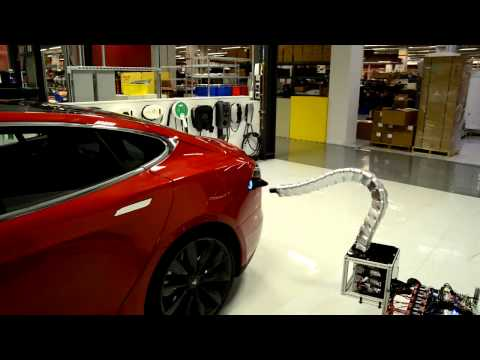

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo('zsAoMkm_DEw', width=533, height=300)

### BrainFlow API

Brainflow generalize communication with various biosensing hardware. higher-order functions that runs in threads, which makes code re-use a lot simpler if OpenBCI GUI can't be used for data aqusition and processing.

TODO: Data rendering path

Signal Filtering -> Denoising -> FFT -> Downsampling

### ~~FFT~~ Periodogram

calculate PSD using Welch method

Welch's method [1] computes an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified periodogram for each segment and averaging the periodograms.



[1] P. Welch, “The use of the fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms”, IEEE Trans. Audio Electroacoust. vol. 15, pp. 70-73, 1967.

In [2]:
# psd_welch_data.py
# Get PSD Welch Data Example from https://brainflow.readthedocs.io/en/stable/Examples.html#python-band-power

import time
import numpy as np

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, WindowFunctions, DetrendOperations


def main():
    BoardShim.enable_dev_board_logger()

    # use SYNTHETIC_BOARD for demo
    params = BrainFlowInputParams()
    params.serial_port = 'COM4'
    board_id = BoardIds.SYNTHETIC_BOARD.value
    board = BoardShim(board_id, params)
    board.prepare_session()
    board.start_stream()
    BoardShim.log_message(LogLevels.LEVEL_INFO.value, 'start sleeping in the main thread')
    time.sleep(10)

    sampling_rate = BoardShim.get_sampling_rate(board_id)
    nfft = DataFilter.get_nearest_power_of_two(sampling_rate)
    window_size = 4
    num_points = window_size * sampling_rate
    data = board.get_board_data(num_points)
    
    board.stop_stream()
    board.release_session()

    eeg_channels = BoardShim.get_eeg_channels(board_id)
    #print(type(eeg_channels))

    # Get PSD Welch data
    for count, channel in enumerate(eeg_channels[:5]):
        psd_data = DataFilter.get_psd_welch(data[channel], nfft, nfft // 2, sampling_rate,
                                   WindowFunctions.BLACKMAN_HARRIS.value) #Returns amplitude and frequency arrays of len N / 2 + 1

        print(f'Amplitude, channel {channel} %s' %psd_data[0])
        print(f'Frequency, channel {channel} %s' %psd_data[1])
        break # Break for printing just the first channel
    
    print(f'Amplitude, {len(psd_data[0])} datapoints')
    print(f'Frequency, {len(psd_data[1])} datapoints')
        
if __name__ == "__main__":
    main()

Amplitude, channel 1 [2.49086770e-04 4.08142346e-04 2.48421761e-03 3.48514147e-01
 4.98458602e+00 1.27893872e+01 7.21981314e+00 7.97022188e-01
 9.71730768e-03 6.08577688e-05 1.50263253e-04 2.85459264e-04
 2.92003709e-04 2.83856434e-04 3.23187098e-04 2.11710250e-04
 1.09340129e-04 1.59919297e-04 2.26933066e-04 1.94689525e-04
 2.01719990e-04 2.42040037e-04 1.98612079e-04 1.87190200e-04
 2.27947723e-04 2.25810412e-04 2.13844586e-04 1.82559083e-04
 1.57926393e-04 1.23605853e-04 1.63102368e-04 2.16810260e-04
 1.40600025e-04 9.34817401e-05 1.80769171e-04 2.50486933e-04
 2.59459717e-04 2.69918560e-04 2.11482188e-04 1.22755013e-04
 5.75313235e-05 6.54118657e-05 1.20041581e-04 1.69116196e-04
 9.96463964e-05 4.54604991e-05 7.63142592e-05 1.93565807e-04
 2.90315899e-04 2.31673588e-04 1.62992114e-04 1.24589272e-04
 1.26842002e-04 2.17441933e-04 2.46067368e-04 1.80621266e-04
 1.64542968e-04 2.03783304e-04 2.16169458e-04 1.92739939e-04
 1.97023981e-04 1.98623269e-04 1.58982495e-04 1.62043120e-04
 1.

In [29]:
# downsample-data.py
# Downsample Data Example from https://brainflow.readthedocs.io/en/stable/Examples.html#python-downsample-data
# 20 dataframes are read and downsampled to 6-10 frames

import time
import numpy as np

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations


def main():
    BoardShim.enable_dev_board_logger()

    # use SYNTHETIC_BOARD for demo
    params = BrainFlowInputParams()
    params.serial_port = 'COM4'
    board_id = BoardIds.SYNTHETIC_BOARD.value
    board = BoardShim(board_id, params)
    board.prepare_session()
    board.start_stream()
    BoardShim.log_message(LogLevels.LEVEL_INFO.value, 'start sleeping in the main thread')
    time.sleep(10)
    data = board.get_board_data(250) # 1 second?
    board.stop_stream()
    board.release_session()

    eeg_channels = BoardShim.get_eeg_channels(board_id)
    #print(type(eeg_channels))
    # demo for downsampling, it just aggregates data
    for count, channel in enumerate(eeg_channels[:5]):
        print('Original data for channel %d:' % channel)
        print(len(data[channel]))
        if count == 0:
            downsampled_data = DataFilter.perform_downsampling(data[channel], 10, AggOperations.MEDIAN.value)
        elif count == 1:
            downsampled_data = DataFilter.perform_downsampling(data[channel], 10, AggOperations.MEAN.value)
        else:
            downsampled_data = DataFilter.perform_downsampling(data[channel], 10, AggOperations.EACH.value) # 10 downsampling periods
        print('Downsampled data for channel %d:' % channel)
        print(len(downsampled_data))
        print(downsampled_data)


if __name__ == "__main__":
    main()

Original data for channel 1:
20
Downsampled data for channel 1:
6
[-187500.02235174 -187500.02235174 -187500.02235174 -187500.02235174
 -187500.02235174 -187500.02235174]
Original data for channel 2:
20
Downsampled data for channel 2:
10
[-187500.02235174 -187500.02235174 -187500.02235174 -187500.02235174
 -187500.02235174 -187500.02235174 -187500.02235174 -187500.02235174
 -187500.02235174 -187500.02235174]
Original data for channel 3:
20
Downsampled data for channel 3:
10
[-187500.02235174 -187500.02235174 -187500.02235174 -187500.02235174
 -187500.02235174 -187500.02235174 -187500.02235174 -187500.02235174
 -187500.02235174 -187500.02235174]
Original data for channel 4:
20
Downsampled data for channel 4:
10
[-187500.02235174 -187500.02235174 -187500.02235174 -187500.02235174
 -187500.02235174 -187500.02235174 -187500.02235174 -187500.02235174
 -187500.02235174 -187500.02235174]
Original data for channel 5:
20
Downsampled data for channel 5:
10
[-187500.02235174 -187500.02235174 -187